In [78]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

llm = ChatOllama(model="llama3.2")
# llm = ChatGroq(model="llama-3.2-90b-vision-preview")


In [79]:
from typing import TypedDict
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langgraph.graph import add_messages


class State(TypedDict):
  messages: list[AnyMessage, add_messages]


In [80]:
from langchain_community.utilities import WikipediaAPIWrapper, DuckDuckGoSearchAPIWrapper
from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchRun, DuckDuckGoSearchResults

wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
search_tool = DuckDuckGoSearchResults()

research_tools = [wiki_tool, search_tool]
llm_with_search_call = llm.bind_tools(research_tools)


In [81]:
def react_research(state):
  return {
    'messages': [llm_with_search_call.invoke(state['messages'])]
  }


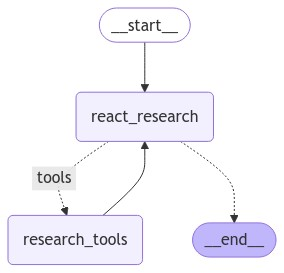

In [87]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)
builder.add_node(react_research)
builder.add_node(ToolNode(research_tools, name="research_tools"))

builder.add_edge(START, 'react_research')
builder.add_conditional_edges('react_research', tools_condition, {'tools': 'research_tools', END: END})
builder.add_edge('research_tools', 'react_research')

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [98]:
from langchain.callbacks.tracers import ConsoleCallbackHandler
config = {
  # "callbacks": [ConsoleCallbackHandler()],
  "configurable": {"thread_id": 1}
}
request = """
Aside from the Apple Remote, what other devices can control the program Apple Remote was originally designed to interact with?
"""
state = {
  "messages": [HumanMessage(content=request)]
}

graph_stream = graph.stream(state, config, stream_mode='updates')


In [99]:
for chunk in graph_stream:
  chunk
  print("\n===\n" * 25)

[14:checkpoint] State at the end of step 14:
{'messages': [AIMessage(content="Here's an answer to the original user question based on the provided tool calls:\n\nWhat types of remotes are compatible with Apple TV?\n\nAccording to my knowledge, there are several options for controlling your Apple TV. You can use a Siri Remote, which is a wireless remote that comes with your Apple TV or purchase one separately. Alternatively, you can use an iPhone or iPad to control your Apple TV using the Apple Remote app, or third-party infrared remotes that comply with the fourth-generation Consumer Electronics Control standard.", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T15:46:13.1402601Z', 'message': {'role': 'assistant', 'content': "Here's an answer to the original user question based on the provided tool calls:\n\nWhat types of remotes are compatible with Apple TV?\n\nAccording to my knowledge, there are several options for controlling your Apple TV. Y